In [1]:
import pandas as pd
import numpy as np
import re
from functools import reduce
import seaborn as sns
from matplotlib import pyplot as plt
from lower_case_dict import d_dict as D_dict
from lower_case_dict import D_ocupaciones
from lower_case_dict import d_describe as D_describe
from traduce import leyenda as tr_leyenda
pd.options.display.max_columns=None
pd.options.display.max_colwidth=310
pd.options.mode.chained_assignment=None

In [2]:
# Dataset completo procesado
ruta='data/formacion_procesado.csv'
df=pd.read_csv(ruta,index_col=0,low_memory=False)

# Naive decision tree

**Clasificador de ocupaciones a partir de títulos al estilo de un arbol de decisión**, con la diferencia de que, en lugar de identificar el punto de corte más explicativo en cada etapa, este clasificador solo reparte en ramas una vez y crea **tantas ramas como títulos distintos** haya en el dataset.   

Para cada título identifica todas las ocupaciones, las ordena de más a menos frecuentes y  selecciona como predicción las ocupaciones en el **top n del ranking de frecuencias** que, además, estén por encima de un **umbral de frecuencia relativa establecido como mínimo**.   

Para cada título, este clasificador devuelve como **predicción una lista de ocupaciones ordenadas** de más a menos probables.   

Los **parámetros de este modelo** son el número n de posiciones en el ranking que se seleccionan como predictores y el umbral de frecuencia mínima.   

El número de ocupaciones en la predicción para cada título puede ser mayor o menor que  n, el número de posiciones en el ranking de frecuencias que se tienen en cuenta:   

- Si alguna ocupación en el top n del ranking tiene una frecuencia inferior al umbral, se descarta como predictor. Así, es posible que la lista de ocupaciones seleccionadas tenga menos de n elementos.  

- Cuando hay empates entre ocupaciones en el top n de frecuencias, se incluyen en la predicción todas las que pertenecen al grupo empatado. Esto hace posible que se seleccionen más de n ocupaciones como predicción. 

El funcionamiento del algoritmo se ha ilustrado empleando las columnas de título y de ocupacion literales en lugar de las nuḿericas. Se ha decidido así porque facilita el hacerse una idea de cuáles son las titulaciones para las que es más o menos probable hacer predicciones acertadas durante el proceso de construcción del clasificador. No obstante, el diseño del algoritmo permite sutituir las columnas literales por las numéricas para operar de forma más eficiente. También permite establecer otros regresores y targets. 


## Objetivo

El objetivo de la construcción de un clasificador elemental es conocer en qué medida las titulaciones universitarias explican por sí solas las profesiones que alcanzan los titulados.   
Se espera un éxito modesto por varios motivos:   

- Los títulos universitarios no son el único critero de los empleadores para seleccionar a su plantilla. Por un lado, un título universitario suele ser insuficiente por sí solo para aspirar a un buen número de puestos de trabajo reservados a universitarios. Por otro lado, a menudo los candidatos a un empleo pueden suplir la falta de un título universitario especializado a menudo con otros méritos, como la experiencia profesional o la formación en disciplinas afines. Los estudios de medicina son una excepción clara a esta posibilidad; los resultados constatan que las profesiones sanitarias están reservadas a titulados con formación especializada (aunque no todos los que tienen esa formación trabajan en ocupaciones relacionadas con su título). 

- Las encuestas empleadas en este proyecto solo informan con detalle de un título universitario de cada encuestado. Aquellos que han accedido a su profesión gracias a un título distinto del que les hace elegibles para la encuesta en la que participan (otro grado, otro máster, un título de doctor) se escapan a la capacidad predictiva de los modelos basados en estos datos.  Esto se notará especialmente en los casos en los que el encuestado responde sobre un título que ha estudiado por motivos distintos a búsqueda de empleo o la promoción profesional mientras trabajaban en ocupaciones a las que accedieron gracias a una titulación previa.  

- El mal funcionamiento del mercado de trabajo español empuja a muchos aspirantes a un empleo a aceptar trabajos poco o nada relacionados con su formación y sus conocimientos.   


## Justificación
**Ventajas de la construcción del algoritmo a medida** (en lugar de emplear una solución estándar):  
- **Simplicidad** de la justificación teórica que sustenta las predicciones. Facilita la interpretación de los resultados.  

- Clasificador **específico** para el caso en el que **el regresor y el target son variables categóricas**.  
  
- El proceso de construcción del algoritmo es, en su mayor parte, un **análisis descriptivo** de las relaciones entre titulaciones y ocupaciones. Este análisis se ha ilustrado y probado con los datos de la encuesta completa para estimar la dificultad del problema de clasificación (que se resuelve, más adelante, sobre subconjuntos de train, validación y test).  
  
- **Flexibilidad** para definir los criterios de agregación de las métricas de evaluación, por titulaciones o por ocupaciones. Facilita la identificación de los títulos y las profesiones para las que es más y menos probable hacer predicciones acertadas. 

# Dataset encuesta 

#### Observaciones con target informado

In [3]:
# Selección: solo ocupaciones informadas
df=df[df['ocupacion'].notna()]
df.shape

(59844, 311)

#### Número de categorías distintas del target: 

In [4]:
df['ocupacion'].nunique()
# Ocupaciones distintas (núm. categorías del target):

62

#### Número de categorías distintas del regresor: 

In [5]:
df['titulo_ppal_'].nunique()
# Titulos distintos (num. categorías del regresor principal): 

173

# Número de ocupaciones distintas por título

### Regresor y target:
En adelante se identifican el título principal como regresor y la ocupación como target. Esto facilitará la generalización del clasificador naive a otros targets y regresores. 

In [6]:
def num_cat_targets_por_cat_regresor(data,regresor,target):
    columnas=[regresor,target]
    out=data[columnas].groupby(regresor).agg(['nunique'])
    out.columns=out.columns.to_flat_index() 
    out.rename(columns={out.columns[-1]:'num categorias target para regresor'},inplace=True)
    out.sort_values(by='num categorias target para regresor',inplace=True)
    out.reset_index(inplace=True)
    
    return out

In [7]:
num_oc_por_titulo_encuesta=num_cat_targets_por_cat_regresor(data=df,regresor='titulo_ppal_',target='ocupacion_')
num_oc_por_titulo_encuesta.head(10)

,titulo_ppal_,num categorias target para regresor
0,Grado Odontología,5
1,Máster Odontología,6
2,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",8
3,Máster Religión y teología,9
4,Máster Lenguas (Otros estudios),10
5,Grado Medicina,10
6,Máster Veterinaria,10
7,Grado Protocolo y eventos,11
8,Máster Estadística,11
9,Máster Enfermería,11


In [8]:
num_oc_por_titulo_encuesta.tail(10)

,titulo_ppal_,num categorias target para regresor
163,"Grado Ingeniería agrícola, agropecuaria y medio rural",50
164,Grado Actividad física y del deporte,50
165,Grado Trabajo social,51
166,Grado Educación infantil,52
167,Grado Ciencias ambientales,52
168,Grado Educación primaria,52
169,Grado Economía,53
170,Grado Historia,53
171,Grado Arquitectura técnica,53
172,Grado Administración y empresa,54


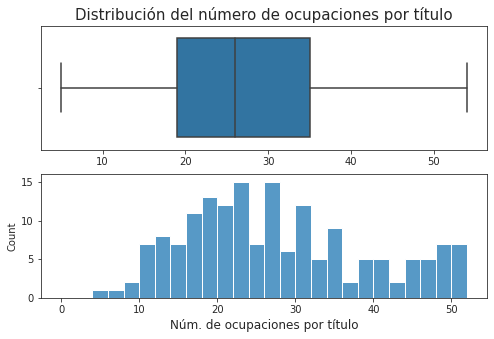

In [9]:
sns.set_style('ticks')

fig, [ax1, ax2] = plt.subplots(2, 1,figsize=(8,5))
font_titles=15
font_labels=12

sns.boxplot(ax=ax1,data=num_oc_por_titulo_encuesta,
            x='num categorias target para regresor')
ax1.set_title('Distribución del número de ocupaciones por título',fontsize=font_titles) 
ax1.set_xlabel('',fontsize=font_labels)

max_num_oc=num_oc_por_titulo_encuesta['num categorias target para regresor'].max()
sns.histplot(ax=ax2,data=num_oc_por_titulo_encuesta,
             x='num categorias target para regresor',
             bins=np.arange(0,max_num_oc,2))
ax2.set_xlabel('Núm. de ocupaciones por título',fontsize=font_labels)
ax2.set_ylim(0,16)

fig.subplots_adjust(hspace=.2)
plt.show()

## Número de ocupaciones distintas por título: resumen 

In [10]:
num_oc_por_titulo_encuesta['num categorias target para regresor'].describe()

count    173.000000
mean      27.705202
std       12.290563
min        5.000000
25%       19.000000
50%       26.000000
75%       35.000000
max       54.000000
Name: num categorias target para regresor, dtype: float64

# Número de ocupaciones distintas por rama de conocimento

In [11]:
# df auxiliar para añadir ramas de conocimiento a la distribución de número de ocupaciones por título
df_ramas=df[['titulo_ppal_','rama_ppal_']].drop_duplicates()
df_ramas.head()

,titulo_ppal_,rama_ppal_
0,Grado Pedagogía,Ciencias sociales y jurídicas
398,Grado Pedagogía,Artes y humanidades
568,Grado Educación infantil,Ciencias sociales y jurídicas
1933,Grado Educación primaria,Ciencias sociales y jurídicas
3840,Grado Otros maestros,Ciencias sociales y jurídicas


In [12]:
num_oc_por_titulo_ramas=num_oc_por_titulo_encuesta.merge(df_ramas,on='titulo_ppal_',how='left')
num_oc_por_titulo_ramas.head()

,titulo_ppal_,num categorias target para regresor,rama_ppal_
0,Grado Odontología,5,Ciencias de la salud
1,Máster Odontología,6,Ciencias de la salud
2,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",8,Ciencias
3,Máster Religión y teología,9,Artes y humanidades
4,Máster Lenguas (Otros estudios),10,Artes y humanidades


[Text(0, 0, 'Ciencias de la salud'),
 Text(1, 0, 'Ciencias'),
 Text(2, 0, 'Artes y humanidades'),
 Text(3, 0, 'Ingeniería y arquitectura'),
 Text(4, 0, 'Ciencias sociales y jurídicas')]

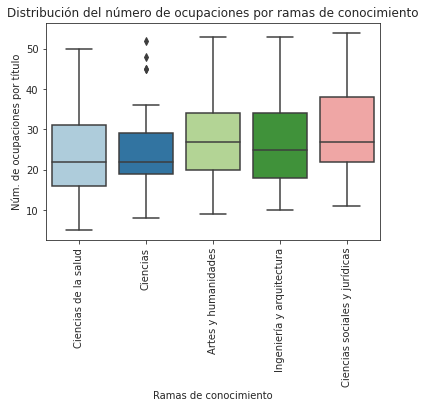

In [13]:
ax = sns.boxplot(data=num_oc_por_titulo_ramas, x='rama_ppal_',\
                                               y='num categorias target para regresor', palette='Paired')
ax.set(title='Distribución del número de ocupaciones por ramas de conocimiento',xlabel='Ramas de conocimiento',
       ylabel='Núm. de ocupaciones por título')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [14]:
df['ambito_g1_'].unique()

array(['Educación (Otros estudios) ',
       'Formación de docentes de enseñanza infantil ',
       'Formación de docentes de enseñanza primaria ',
       'Técnicas audiovisuales y medios de comunicación ',
       'Artes (Otros estudios) ', 'Humanidades ', 'Lenguas ', 'Economía ',
       'Ciencias sociales y del comportamiento (Otros estudios) ',
       'Psicología ', 'Periodismo y documentación ',
       'Negocios y administración (Otros estudios) ',
       'Dirección y administración ', 'Derecho ', 'Ciencias de la vida ',
       'Medio ambiente ', 'Ciencias químicas, físicas y geológicas ',
       'Matemáticas y estadística ', 'Informática',
       'Ingeniería y profesiones afines ',
       'Industria manufacturera y producción ',
       'Arquitectura y construcción ', 'Agricultura y ganadería ',
       'Silvicultura ', 'Veterinaria ', 'Salud (Otros estudios) ',
       'Medicina ', 'Enfermería ', 'Servicios sociales ',
       'Actividades físicas y deportivas ', 'Viajes, turismo y oc

In [15]:
df['ambito_m1_'].unique()

array([nan, 'SALUD Y SERVICIOS SOCIALES', 'EDUCACIÓN', 'INFORMÁTICA',
       'CIENCIAS', 'INGENIERÍA, INDUSTRIA Y CONSTRUCCIÓN',
       'NEGOCIOS, ADMINISTRACIÓN Y DERECHO', 'SERVICIOS',
       'CIENCIAS SOCIALES, PERIODISMO Y DOCUMENTACIÓN',
       'ARTES Y HUMANIDADES',
       'AGRICULTURA, GANADERÍA, SILVICULTURA, PESCA Y VETERINARIA'],
      dtype=object)

## Número de titulados por título: 

In [16]:
def num_obs_por_cat_regresor(data,regresor,target):
    
    columnas=[regresor,target]
    out=data[columnas].groupby([regresor]).agg(['count'])
    out.columns=out.columns.to_flat_index()
    out.reset_index(inplace=True)
    out.rename(columns={out.columns[-1]:'obs regresor'},inplace=True)
    
    previo=num_cat_targets_por_cat_regresor(data=data,regresor=regresor,target=target)
    out=out.merge(previo,on=regresor,how='outer')
    out=out.sort_values(by='num categorias target para regresor')
    out.reset_index(drop=True,inplace=True)
    
    return out

In [17]:
num_titulados_encuesta=num_obs_por_cat_regresor(data=df,regresor='titulo_ppal_',target='ocupacion_')
num_titulados_encuesta.head()

,titulo_ppal_,obs regresor,num categorias target para regresor
0,Grado Odontología,243,5
1,Máster Odontología,73,6
2,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",31,8
3,Máster Religión y teología,25,9
4,Máster Lenguas (Otros estudios),53,10


In [18]:
num_titulados_encuesta.tail()

,titulo_ppal_,obs regresor,num categorias target para regresor
168,Grado Educación primaria,2065,52
169,Grado Economía,1174,53
170,Grado Historia,697,53
171,Grado Arquitectura técnica,1050,53
172,Grado Administración y empresa,2637,54


## Número de profesionales por título y ocupación: 

In [19]:
def num_cat_target_por_regresor_y_target(data,regresor,target):
    
    columnas=[regresor,target]
    out=data[columnas].groupby(regresor).agg(['value_counts'])
    out.columns=out.columns.to_flat_index()
    out.reset_index(inplace=True)
    out.rename(columns={out.columns[-1]:'obs target'},inplace=True)
    
    previo=num_obs_por_cat_regresor(data=data,regresor=regresor,target=target)
    out=previo.merge(out,on=regresor,how='outer')
    out.sort_values(by=['num categorias target para regresor','obs target'],ascending=[True,False],inplace=True)
    
    return out

In [20]:
prof_por_oc_y_titulo_encuesta=num_cat_target_por_regresor_y_target(data=df,
                                                                   regresor='titulo_ppal_',target='ocupacion_')
prof_por_oc_y_titulo_encuesta.head()

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target
0,Grado Odontología,243,5,Prof sanitarios,237
1,Grado Odontología,243,5,Gerentes em servicios excepto hostelería y comercio,2
2,Grado Odontología,243,5,Prof enseñanza,2
3,Grado Odontología,243,5,Directores producción y operaciones,1
4,Grado Odontología,243,5,Trabajadores servicios de cuidados de salud,1


In [21]:
prof_por_oc_y_titulo_encuesta.tail()

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target
4788,Grado Administración y empresa,2637,54,Montadores y ensambladores en fábricas,1
4789,Grado Administración y empresa,2637,54,Peones de construcción y minería,1
4790,Grado Administración y empresa,2637,54,Trabajadores construcción e instalaciones: acabado,1
4791,Grado Administración y empresa,2637,54,Trabajadores construcción y afines: estructura,1
4792,Grado Administración y empresa,2637,54,Trabajadores servicios de cuidados no de salud,1


## Proporción de profesionales sobre titulados por ocupación y título
Frecuencias relativas y frecuencias relativas acumuadas de las ocupaciones para cada título.   
(*) Para calcular las frecuencias acumuladas se ordenan las ocupaciones por frecuencia relativa en orden descendente. 

In [22]:
def frecuencias_cat_target_por_regresor(data,regresor,target):
    
    previo=num_cat_target_por_regresor_y_target(data=data,regresor=regresor,target=target)
    # 'prop' = proporción de obs. del target sobre núm. obs. para la categoría del regresor: 
    previo['prop']=previo['obs target'].div(previo['obs regresor'])
    
    # Frecuencias acumuladas: 
    acum=previo[[regresor,'prop']].groupby(regresor).cumsum()
    acum.rename(columns={acum.columns[-1]:'prop acum'},inplace=True)
    
    out=previo.merge(acum,left_index=True,right_index=True,how='outer')
    
    
    return out

In [23]:
proporciones_encuesta=frecuencias_cat_target_por_regresor(data=df,regresor='titulo_ppal_',target='ocupacion_')
proporciones_encuesta.head()

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target,prop,prop acum
0,Grado Odontología,243,5,Prof sanitarios,237,0.975309,0.975309
1,Grado Odontología,243,5,Gerentes em servicios excepto hostelería y comercio,2,0.008230,0.983539
2,Grado Odontología,243,5,Prof enseñanza,2,0.008230,0.991770
3,Grado Odontología,243,5,Directores producción y operaciones,1,0.004115,0.995885
4,Grado Odontología,243,5,Trabajadores servicios de cuidados de salud,1,0.004115,1.000000


In [24]:
proporciones_encuesta.tail()

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target,prop,prop acum
4788,Grado Administración y empresa,2637,54,Montadores y ensambladores en fábricas,1,0.000379,0.998483
4789,Grado Administración y empresa,2637,54,Peones de construcción y minería,1,0.000379,0.998862
4790,Grado Administración y empresa,2637,54,Trabajadores construcción e instalaciones: acabado,1,0.000379,0.999242
4791,Grado Administración y empresa,2637,54,Trabajadores construcción y afines: estructura,1,0.000379,0.999621
4792,Grado Administración y empresa,2637,54,Trabajadores servicios de cuidados no de salud,1,0.000379,1.000000


## Ranking de ocupaciones por título: 

In [25]:
def ranking_cat_target_por_cat_regresor(data,regresor,target):
    
    previo=frecuencias_cat_target_por_regresor(data=data,regresor=regresor,target=target)
    rank=previo[[regresor,'obs target']]
    rank=rank.groupby(regresor).rank(method='min',ascending=False)
    rank.rename(columns={rank.columns[-1]:'rank'},inplace=True)
    
    out=previo.merge(rank,how='outer',left_index=True,right_index=True)
    out.sort_values(by=['num categorias target para regresor','rank'],inplace=True)
    
    return out 

In [26]:
ranking_encuesta=ranking_cat_target_por_cat_regresor(data=df,regresor='titulo_ppal_',target='ocupacion_')
ranking_encuesta.head()

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target,prop,prop acum,rank
0,Grado Odontología,243,5,Prof sanitarios,237,0.975309,0.975309,1.0
1,Grado Odontología,243,5,Gerentes em servicios excepto hostelería y comercio,2,0.008230,0.983539,2.0
2,Grado Odontología,243,5,Prof enseñanza,2,0.008230,0.991770,2.0
3,Grado Odontología,243,5,Directores producción y operaciones,1,0.004115,0.995885,4.0
4,Grado Odontología,243,5,Trabajadores servicios de cuidados de salud,1,0.004115,1.000000,4.0


In [27]:
ranking_encuesta.tail()

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target,prop,prop acum,rank
4788,Grado Administración y empresa,2637,54,Montadores y ensambladores en fábricas,1,0.000379,0.998483,48.0
4789,Grado Administración y empresa,2637,54,Peones de construcción y minería,1,0.000379,0.998862,48.0
4790,Grado Administración y empresa,2637,54,Trabajadores construcción e instalaciones: acabado,1,0.000379,0.999242,48.0
4791,Grado Administración y empresa,2637,54,Trabajadores construcción y afines: estructura,1,0.000379,0.999621,48.0
4792,Grado Administración y empresa,2637,54,Trabajadores servicios de cuidados no de salud,1,0.000379,1.000000,48.0


In [28]:
# Inspección: 
ranking_encuesta[ranking_encuesta['titulo_ppal_']=='Grado Pedagogía']







# Falta más inspección títulos y núm categorías. 

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target,prop,prop acum,rank
3427,Grado Pedagogía,816,44,Prof enseñanza,380,0.465686,0.465686,1.0
3428,Grado Pedagogía,816,44,Prof eduación especial y no reglada,116,0.142157,0.607843,2.0
3429,Grado Pedagogía,816,44,Prof ciencias sociales,49,0.060049,0.667892,3.0
3430,Grado Pedagogía,816,44,Dependientes de comercio,33,0.040441,0.708333,4.0
3431,Grado Pedagogía,816,44,"Prof apoyo servicios jurídicos, socio-culturales, deportivos",24,0.029412,0.737745,5.0
3432,Grado Pedagogía,816,44,Trabajadores servicios de cuidados no de salud,22,0.026961,0.764706,6.0
3433,Grado Pedagogía,816,44,"Expertos en gestión, finanzas, comercio, etc",20,0.024510,0.789216,7.0
3434,Grado Pedagogía,816,44,Otros empleados administrativos con atención al público,18,0.022059,0.811275,8.0
3435,Grado Pedagogía,816,44,Prof sanitarios,17,0.020833,0.832108,9.0
3436,Grado Pedagogía,816,44,Empleados administrativos sin atención al público,12,0.014706,0.846814,10.0


# Ranking de ocupaciones más frecuentes por título (clasificador naive) 

Equivalente al proceso de entrenamiento.

In [29]:
def naive_fit(data,regresor,target,max_rank,min_prop):
    
    previo=ranking_cat_target_por_cat_regresor(data=data,regresor=regresor,target=target)
    
    naive=previo[previo['rank']<=max_rank]
    naive=naive[naive['prop']>=min_prop]
    
    naive.sort_values(by=['num categorias target para regresor',regresor,'rank'],inplace=True)
    naive.reset_index(drop=True,inplace=True)
    naive.rename(columns={regresor:'regresor: '+regresor, target:'target: '+target},inplace=True)
    
    return naive

In [30]:
naive_encuesta=naive_fit(data=df,regresor='titulo_ppal_',target='ocupacion_',max_rank=5,min_prop=0.05)
naive_encuesta.sample(2)

,regresor: titulo_ppal_,obs regresor,num categorias target para regresor,target: ocupacion_,obs target,prop,prop acum,rank
628,Grado Educación infantil,1882,52,Prof eduación especial y no reglada,116,0.061637,0.701382,2.0
74,Máster Música y artes del espectáculo,90,14,Prof eduación especial y no reglada,18,0.200000,0.788889,2.0


In [31]:
#with pd.option_context("display.max_rows", naive_encuesta.shape[0]):
#    display(naive_encuesta)

# Entrenamiento, validación y test
Se separan los dataset de train, validación y test sin distinguir regresores y target porque es más conveniente mantener todas las columnas en un dataframe único para aplicar el algoritmo y evaluar los resultados. 

In [32]:
def train_vld_test(df):
    df.sample(frac=1,random_state=23) # reordenación aleatoria
    n_train=int(df.shape[0]*0.8*0.8)
    n_vld=int(df.shape[0]*0.8)
    df_train=df[:n_train]
    df_vld=df[n_train:n_vld]
    df_test=df[n_vld:]
    
    return df_train, df_vld, df_test

In [33]:
df_train, df_vld, df_test =train_vld_test(df)
df_train.shape[0]+df_vld.shape[0]+df_test.shape[0]==df.shape[0] # Comprobación

True

In [34]:
prop_tt_encuesta=df['titulo_ppal_'].value_counts(normalize=True)
prop_tt_train=df_train['titulo_ppal_'].value_counts(normalize=True)
compara_prop=pd.DataFrame({'encuesta':prop_tt_encuesta,'train':prop_tt_train})
compara_prop.sort_values(by='encuesta',ascending=False,inplace=True)
compara_prop

,encuesta,train
Grado Administración y empresa,0.044065,0.045875
Grado Enfermería,0.038935,0.030000
Grado Derecho,0.036746,0.034961
Grado Informática,0.036578,0.026632
Grado Educación primaria,0.034506,0.041462
...,...,...
Grado Arqueología,0.000568,0.000888
"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",0.000518,0.000809
Máster Religión y teología,0.000418,0.000653
Grado Protocolo y eventos,0.000384,0.000601


In [35]:
compara_prop['dif abs']=compara_prop['encuesta']-compara_prop['train']
compara_prop['dif_r']=compara_prop['dif abs'].div(compara_prop['encuesta'])
#compara_prop.sort_values(by='encuesta',ascending=False,inplace=True)
compara_prop[compara_prop['dif_r'].abs()>0.2]

,encuesta,train,dif abs,dif_r
Grado Enfermería,0.038935,0.030000,0.008935,0.229476
Grado Informática,0.036578,0.026632,0.009947,0.271925
Grado Educación primaria,0.034506,0.041462,-0.006956,-0.201579
Máster Formación de docentes de educación secundaria y formación profesional,0.028908,0.045170,-0.016261,-0.562507
Grado Medicina,0.023946,0.019034,0.004912,0.205117
...,...,...,...,...
Grado Arqueología,0.000568,0.000888,-0.000320,-0.562507
"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",0.000518,0.000809,-0.000291,-0.562507
Máster Religión y teología,0.000418,0.000653,-0.000235,-0.562507
Grado Protocolo y eventos,0.000384,0.000601,-0.000216,-0.562507


In [36]:
compara_prop[compara_prop['dif_r'].abs()>0.2].nunique()

encuesta    101
train        91
dif abs     101
dif_r        33
dtype: int64

In [37]:
compara_prop.nunique()
# Es preferible un muestreo estratificado

encuesta    144
train       127
dif abs     154
dif_r        86
dtype: int64

# Predicciones 

In [38]:
def naive_prediccion_instrumental(clasificador,valor_regresor):
    """ Predicciones y probabilidades para el valor del regresor según el clasificador entrenado.
    Conserva el número de categorías del target para cada categoría del regresor para usarlo en evaluación.
    """
    import re
    regresor=list(filter(lambda col: col.startswith('regresor:'),clasificador.columns))[0]
    target=list(filter(lambda col: col.startswith('target:'),clasificador.columns))[0]
    
    modelo=clasificador[clasificador[regresor]==valor_regresor]
    prediccion=modelo[[target,'prop','num categorias target para regresor']]
    prediccion.reset_index(drop=True,inplace=True)
    prediccion.rename(columns={target:'prediccion','prop':'probabilidad'},inplace=True)
    
    return prediccion

In [39]:
def naive_prediccion(clasificador,valor_regresor):
    """ Predicción en el formato en el que se muestra al interesado
    """
    prediccion=naive_prediccion_instrumental(clasificador,valor_regresor)
    prediccion=prediccion[['prediccion','probabilidad']]

    return prediccion

In [40]:
# Fit en train:
naive_5_05_train=naive_fit(data=df_train,regresor='titulo_ppal_',target='ocupacion_',max_rank=5,min_prop=0.05)
naive_5_05_train.head()  

,regresor: titulo_ppal_,obs regresor,num categorias target para regresor,target: ocupacion_,obs target,prop,prop acum,rank
0,Grado Odontología,125,4,Prof sanitarios,120,0.960000,0.960000,1.0
1,Máster Odontología,73,6,Prof sanitarios,66,0.904110,0.904110,1.0
2,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",31,8,Prof enseñanza,12,0.387097,0.387097,1.0
3,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",31,8,"Prof ciencias, matemáticas e ingeniería",5,0.161290,0.548387,2.0
4,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",31,8,Profesionales IT,4,0.129032,0.677419,3.0


In [41]:
naive_5_05_train.tail()

,regresor: titulo_ppal_,obs regresor,num categorias target para regresor,target: ocupacion_,obs target,prop,prop acum,rank
674,Grado Administración y empresa,1757,52,"Expertos en gestión, finanzas, comercio, etc",344,0.195788,0.195788,1.0
675,Grado Administración y empresa,1757,52,"Empleados servicios financieros, contables y de apoyo",246,0.140011,0.335800,2.0
676,Grado Administración y empresa,1757,52,Empleados administrativos sin atención al público,218,0.124075,0.459875,3.0
677,Grado Administración y empresa,1757,52,Representantes e intermediarios,113,0.064314,0.524189,4.0
678,Grado Administración y empresa,1757,52,Prof derecho,97,0.055208,0.579397,5.0


In [42]:
# Inspección: 
naive_prediccion_instrumental(clasificador=naive_5_05_train,valor_regresor='Máster Odontología')

,prediccion,probabilidad,num categorias target para regresor
0,Prof sanitarios,0.90411,6


In [43]:
# Inspección: 
naive_prediccion(naive_5_05_train,valor_regresor='Grado Economía')

,prediccion,probabilidad
0,"Expertos en gestión, finanzas, comercio, etc",0.182504
1,"Empleados servicios financieros, contables y de apoyo",0.138763
2,Empleados administrativos sin atención al público,0.096531
3,Otros empleados administrativos con atención al público,0.067873
4,Representantes e intermediarios,0.063348


In [44]:
# Inspección: 
naive_prediccion(naive_5_05_train,valor_regresor='Grado Matemáticas')

,prediccion,probabilidad
0,Prof enseñanza,0.394040
1,Profesionales IT,0.145695
2,"Prof ciencias, matemáticas e ingeniería",0.119205
3,Técnicos TI,0.096026
4,"Expertos en gestión, finanzas, comercio, etc",0.072848


In [45]:
# Inspección: Ilustra empate múltiple
naive_prediccion(naive_5_05_train,valor_regresor='Máster Servicios de transporte')

,prediccion,probabilidad
0,"Prof ciencias, matemáticas e ingeniería",0.230769
1,Técnicos ciencias e ingenierías,0.092308
2,"Empleados servicios financieros, contables y de apoyo",0.061538
3,"Expertos en gestión, finanzas, comercio, etc",0.061538
4,Ocupaciones militares,0.061538
5,Prof apoyo gestión administrativa,0.061538
6,"Supervisores ingeniería, industria y construcción",0.061538


# Evaluación del clasificador

In [46]:
def naive_evalua(clasificador, data):
    
    import re
    regresor=list(filter(lambda col: col.startswith('regresor:'),clasificador.columns))[0].split(' ')[1]
    target=list(filter(lambda col: col.startswith('target:'),clasificador.columns))[0].split(' ')[1]
    
    # evalua: dataset con regresores y targets en el set de evaluación
    evalua=data[[regresor,target]]
    
    # Columnas con predicciones (lista targets predichos y lista probabilidades)
    evalua['prediccion']=evalua[regresor]\
                .apply(lambda valor: naive_prediccion_instrumental(clasificador,valor)['prediccion'].tolist())
    evalua['prediccion probs']=evalua[regresor]\
                .apply(lambda valor: naive_prediccion_instrumental(clasificador,valor)['probabilidad'].tolist())
    
    # Núm predicciones:
    evalua['num pred por regresor']=evalua['prediccion'].apply(lambda lista:len(lista))
    
    # Núm. categorías del target por regresor en el set de train:
    evalua['cat target por regresor (train)']=evalua[regresor]\
            .apply(lambda valor:\
            naive_prediccion_instrumental(clasificador,valor)['num categorias target para regresor'].unique()[0])

    # Columna 'acierto' (binaria)
    evalua['acierto']=evalua.apply(lambda row: row[target] in row['prediccion'],axis=1).astype(int)
    
    # Posición de predicción acertada: 
    evalua['posicion acierto']=evalua[evalua['acierto']==1]\
                              .apply(lambda row: row['prediccion'].index(row[target])+1,axis=1)
    
    # Columna 'probabilidad asociada la predicción acertada' (numerador de acierto ajustado por probabilidad):
    evalua['prob pred acertada']=evalua[evalua['acierto']==1]\
                            .apply(lambda row: row['prediccion probs'][int(row['posicion acierto'])-1],axis=1)
    
    # Columna 'suma de probabilidades de predicciones' (denominador de acierto ajustado por probabilidad):
    evalua['suma prob prediccion']=evalua['prediccion probs'].apply(lambda lista: sum(lista))
    
    # Acierto ajustado: proporción de la probabilidad de predicción acertada sobre suma probs. de predicciones:  
    evalua['acierto ajustado']=evalua[evalua['acierto']==1]['prob pred acertada']\
                              .div(evalua[evalua['acierto']==1]['suma prob prediccion'])
    
    
    del evalua['prediccion probs']
    
    # Num. de observaciones para cada categoría del regresor:
    total_obs_por_cat_regresor=evalua[[regresor,'acierto']].groupby(regresor).agg(['count'])
    total_obs_por_cat_regresor.columns=total_obs_por_cat_regresor.columns.to_flat_index()
    evalua=evalua.merge(total_obs_por_cat_regresor,on=regresor,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'num obs regresor'},inplace=True)
    
    # Núm. de aciertos (binaria) para cada categoría del regresor: 
    aciertos_por_cat_regresor=evalua[[regresor,'acierto']].groupby(regresor).agg(['sum'])
    aciertos_por_cat_regresor.columns=aciertos_por_cat_regresor.columns.to_flat_index()
    evalua=evalua.merge(aciertos_por_cat_regresor,on=regresor,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'num aciertos por cat regresor'},inplace=True)
    
    # Suma aciertos ajustados por prob para cada categoría del regresor: 
    acierto_ajustado_por_cat_regresor=evalua[[regresor,'acierto ajustado']].groupby(regresor).agg(['sum'])
    acierto_ajustado_por_cat_regresor.columns=acierto_ajustado_por_cat_regresor.columns.to_flat_index()
    evalua=evalua.merge(acierto_ajustado_por_cat_regresor,on=regresor,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'aciertos ajustados por cat regresor'},inplace=True)
    
    # Accuracy y accuracy ajustado para cada categoría del regresor: 
    evalua['accuracy regresor']=evalua['num aciertos por cat regresor'].div(evalua['num obs regresor'])
    evalua['accuracy ajustado regresor']=evalua['aciertos ajustados por cat regresor']\
                                        .div(evalua['num obs regresor'])
    
    total_obs=evalua.shape[0]
    
    # Accuracy y accuracy ajustado poderados de cada categoría del regresor: 
    evalua['peso regresor']=evalua['num obs regresor']/total_obs
    evalua['accuracy ponderado regresor']=evalua['accuracy regresor']*evalua['peso regresor']
    evalua['accuracy ajustado ponderado regresor']=evalua['accuracy ajustado regresor']*evalua['peso regresor']
    
    # Num. de observaciones para cada categoría del target:
    total_obs_por_cat_target=evalua[[target,'acierto']].groupby(target).agg(['count'])
    total_obs_por_cat_target.columns=total_obs_por_cat_target.columns.to_flat_index()
    evalua=evalua.merge(total_obs_por_cat_target,on=target,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'num obs target'},inplace=True)
    
    # Núm. de aciertos (binaria) para cada categoría del target: 
    aciertos_por_cat_target=evalua[[target,'acierto']].groupby(target).agg(['sum'])
    aciertos_por_cat_target.columns=aciertos_por_cat_target.columns.to_flat_index()
    evalua=evalua.merge(aciertos_por_cat_target,on=target,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'num aciertos por cat target'},inplace=True)
    
    # Suma aciertos ajustados por prob para cada categoría del target: 
    acierto_ajustado_por_cat_target=evalua[[target,'acierto ajustado']].groupby(target).agg(['sum'])
    acierto_ajustado_por_cat_target.columns=acierto_ajustado_por_cat_target.columns.to_flat_index()
    evalua=evalua.merge(acierto_ajustado_por_cat_target,on=target,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'aciertos ajustados por cat target'},inplace=True)
  
    # Recall y recall ajustado para cada categoría del target:
    evalua['recall target']=evalua['num aciertos por cat target'].div(evalua['num obs target'])
    evalua['recall ajustado target']=evalua['aciertos ajustados por cat target'].div(evalua['num obs target'])
    
    # Recall y recall ajustado ponderados para cada categoría del target: 
    evalua['peso target']=evalua['num obs target']/total_obs
    evalua['recall ponderado target']=evalua['recall target']*evalua['peso target']
    evalua['recall ajustado ponderado target']=evalua['recall ajustado target']*evalua['peso target']
    
    # Formato:
    evalua.rename(columns={regresor:'regresor: '+regresor, target:'target: '+target},inplace=True)
    
    return evalua

### Evaluación desagregada (en train):

In [47]:
naive_5_05_evalua_train=naive_evalua(clasificador=naive_5_05_train, data=df_train)
naive_5_05_evalua_train.sample(2)

,regresor: titulo_ppal_,target: ocupacion_,prediccion,num pred por regresor,cat target por regresor (train),acierto,posicion acierto,prob pred acertada,suma prob prediccion,acierto ajustado,num obs regresor,num aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor,num obs target,num aciertos por cat target,aciertos ajustados por cat target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target
28278,Grado Ingeniería electrónica industrial y automática,"Prof ciencias, matemáticas e ingeniería","[Prof ciencias, matemáticas e ingeniería, Técnicos ciencias e ingenierías, Prof enseñanza, Profesionales IT]",4,37,1,1.0,0.565144,0.761421,0.742222,591,450,258.231111,0.761421,0.436939,0.015431,0.011749,0.006742,4894,4511,2675.562971,0.921741,0.546703,0.127781,0.117781,0.069858
28571,Grado Ingeniería en tecnologías industriales,"Prof ciencias, matemáticas e ingeniería","[Prof ciencias, matemáticas e ingeniería, Técnicos ciencias e ingenierías, Profesionales IT]",3,40,1,1.0,0.517467,0.641921,0.806122,458,294,196.659864,0.641921,0.429388,0.011958,0.007676,0.005135,4894,4511,2675.562971,0.921741,0.546703,0.127781,0.117781,0.069858


In [48]:
naive_5_05_evalua_train.head(5)

,regresor: titulo_ppal_,target: ocupacion_,prediccion,num pred por regresor,cat target por regresor (train),acierto,posicion acierto,prob pred acertada,suma prob prediccion,acierto ajustado,num obs regresor,num aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor,num obs target,num aciertos por cat target,aciertos ajustados por cat target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target
0,Grado Pedagogía,Prof enseñanza,"[Prof enseñanza, Prof eduación especial y no reglada]",2,36,1,1.0,0.438034,0.59188,0.740072,468,277,170.429603,0.59188,0.364166,0.012219,0.007232,0.00445,6897,6425,4259.942752,0.931564,0.617652,0.180078,0.167755,0.111226
1,Grado Pedagogía,Prof enseñanza,"[Prof enseñanza, Prof eduación especial y no reglada]",2,36,1,1.0,0.438034,0.59188,0.740072,468,277,170.429603,0.59188,0.364166,0.012219,0.007232,0.00445,6897,6425,4259.942752,0.931564,0.617652,0.180078,0.167755,0.111226
2,Grado Pedagogía,Prof enseñanza,"[Prof enseñanza, Prof eduación especial y no reglada]",2,36,1,1.0,0.438034,0.59188,0.740072,468,277,170.429603,0.59188,0.364166,0.012219,0.007232,0.00445,6897,6425,4259.942752,0.931564,0.617652,0.180078,0.167755,0.111226
3,Grado Pedagogía,Prof enseñanza,"[Prof enseñanza, Prof eduación especial y no reglada]",2,36,1,1.0,0.438034,0.59188,0.740072,468,277,170.429603,0.59188,0.364166,0.012219,0.007232,0.00445,6897,6425,4259.942752,0.931564,0.617652,0.180078,0.167755,0.111226
4,Grado Pedagogía,Prof enseñanza,"[Prof enseñanza, Prof eduación especial y no reglada]",2,36,1,1.0,0.438034,0.59188,0.740072,468,277,170.429603,0.59188,0.364166,0.012219,0.007232,0.00445,6897,6425,4259.942752,0.931564,0.617652,0.180078,0.167755,0.111226


In [49]:
accuracy_global_train=naive_5_05_evalua_train['acierto'].sum()/naive_5_05_evalua_train['acierto'].count()
accuracy_global_train

0.6693211488250653

### Evaluación desagregada (en validación):

In [50]:
naive_5_05_evalua_vld=naive_evalua(clasificador=naive_5_05_train, data=df_vld)

In [51]:
naive_5_05_evalua_vld.head(2)

,regresor: titulo_ppal_,target: ocupacion_,prediccion,num pred por regresor,cat target por regresor (train),acierto,posicion acierto,prob pred acertada,suma prob prediccion,acierto ajustado,num obs regresor,num aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor,num obs target,num aciertos por cat target,aciertos ajustados por cat target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target
0,Grado Informática,"Prof ciencias, matemáticas e ingeniería","[Profesionales IT, Técnicos TI, Prof ciencias, matemáticas e ingeniería, Prof enseñanza]",4,41,1,3.0,0.091176,0.766667,0.118926,457,433,132.602302,0.947484,0.290158,0.047728,0.045222,0.013849,1209,1133,515.888606,0.937138,0.426707,0.126266,0.118329,0.053879
1,Grado Informática,"Prof ciencias, matemáticas e ingeniería","[Profesionales IT, Técnicos TI, Prof ciencias, matemáticas e ingeniería, Prof enseñanza]",4,41,1,3.0,0.091176,0.766667,0.118926,457,433,132.602302,0.947484,0.290158,0.047728,0.045222,0.013849,1209,1133,515.888606,0.937138,0.426707,0.126266,0.118329,0.053879


In [52]:
accuracy_global_vld=naive_5_05_evalua_vld['acierto'].sum()/naive_5_05_evalua_vld['acierto'].count()
accuracy_global_vld

0.6762402088772846

# Métricas de evaluación: accuracy

In [53]:
def naive_evalua_accuracy(clasificador,data):
    
    evalua=naive_evalua(clasificador=clasificador,data=data)
    
    import re
    lista_re_regresor=list(filter(lambda col: re.search('.*regresor.*',col),evalua.columns))
    
    evalua=evalua[lista_re_regresor].drop_duplicates()
    evalua.set_index(evalua.columns[0],inplace=True)
    evalua.sort_values(by='accuracy regresor',ascending=False,inplace=True)

    return evalua

In [54]:
naive_5_05_evalua_accuracy_vld=naive_evalua_accuracy(clasificador=naive_5_05_train,data=df_vld)

In [55]:
naive_5_05_evalua_accuracy_vld.shape, df_vld['titulo_ppal_'].nunique() # Comprobación: 

((49, 10), 49)

In [56]:
naive_5_05_evalua_accuracy_vld.head()

,num pred por regresor,cat target por regresor (train),num obs regresor,num aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor
regresor: titulo_ppal_,,,,,,,,,,
Grado Medicina,1,9,704,702,702.000000,0.997159,0.997159,0.073525,0.073316,0.073316
Grado Odontología,1,4,118,117,117.000000,0.991525,0.991525,0.012324,0.012219,0.012219
Grado Ingeniería electrónica industrial y automática,4,37,59,56,35.737778,0.949153,0.605725,0.006162,0.005849,0.003732
Grado Informática,4,41,457,433,132.602302,0.947484,0.290158,0.047728,0.045222,0.013849
Grado Ingeniería naval y oceánica,4,23,31,29,13.180556,0.935484,0.425179,0.003238,0.003029,0.001377


In [57]:
naive_5_05_evalua_accuracy_vld.tail()

,num pred por regresor,cat target por regresor (train),num obs regresor,num aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor
regresor: titulo_ppal_,,,,,,,,,,
Grado Publicidad y relaciones públicas,4,36,323,128,51.383333,0.396285,0.159082,0.033734,0.013368,0.005366
Grado Historia del arte,5,35,158,58,12.933333,0.367089,0.081857,0.016501,0.006057,0.001351
Grado Política y gestión pública,4,34,117,41,11.671642,0.350427,0.099758,0.012219,0.004282,0.001219
Grado Bellas artes,5,44,201,65,11.146341,0.323383,0.055454,0.020992,0.006789,0.001164
Grado Historia,4,47,273,83,35.571429,0.304029,0.130298,0.028512,0.008668,0.003715


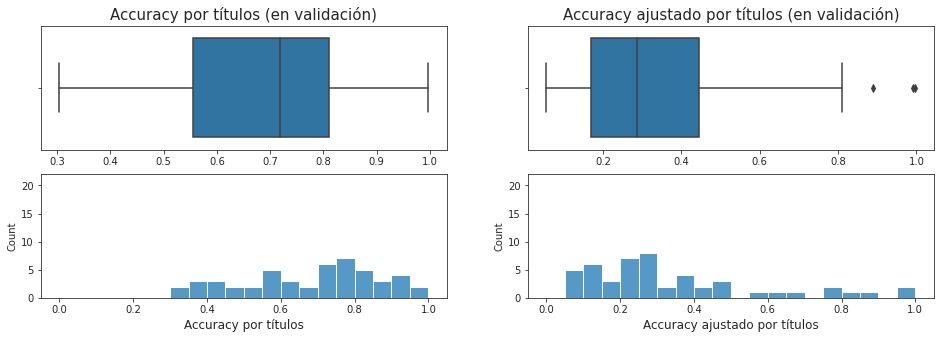

In [58]:
sns.set_style('ticks')

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2,figsize=(16,5))
font_titles=15
font_labels=12

sns.boxplot(ax=ax1,data=naive_5_05_evalua_accuracy_vld,
            x='accuracy regresor')
ax1.set_title('Accuracy por títulos (en validación)',fontsize=font_titles) 
ax1.set_xlabel('',fontsize=font_labels)

sns.boxplot(ax=ax2,data=naive_5_05_evalua_accuracy_vld,
            x='accuracy ajustado regresor')
ax2.set_title('Accuracy ajustado por títulos (en validación)',fontsize=font_titles)
ax2.set_xlabel('',fontsize=font_labels)

sns.histplot(ax=ax3,data=naive_5_05_evalua_accuracy_vld,
             x='accuracy regresor',
             bins=np.arange(0,1.05,0.05))
ax3.set_xlabel('Accuracy por títulos',fontsize=font_labels)
ax3.set_ylim(0,22)

sns.histplot(ax=ax4,data=naive_5_05_evalua_accuracy_vld,
             x='accuracy ajustado regresor',
             bins=np.arange(0,1.05,0.05))
ax4.set_xlabel('Accuracy ajustado por títulos',fontsize=font_labels)
ax4.set_ylim(0,22)

fig.subplots_adjust(hspace=.2)
plt.show()

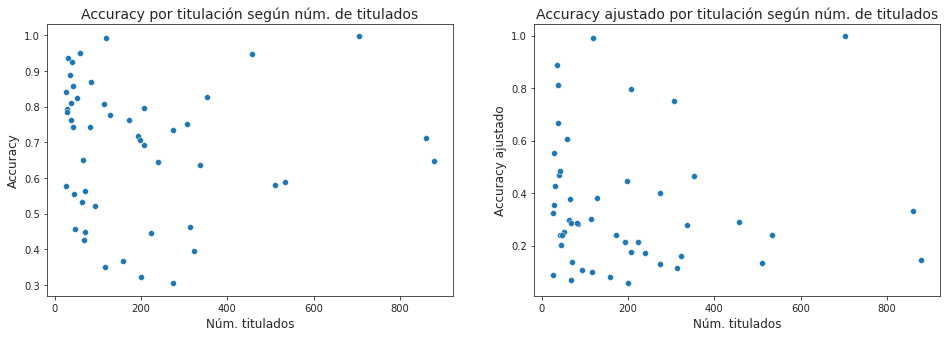

In [59]:
sns.set_style('ticks')

fig, [ax1, ax2] = plt.subplots(1, 2,figsize=(16,5))
font_titles=14
font_labels=12

sns.scatterplot(ax=ax1,data=naive_5_05_evalua_accuracy_vld,
                x='num obs regresor',
                y='accuracy regresor')
ax1.set_title('Accuracy por titulación según núm. de titulados',fontsize=font_titles) 
ax1.set_xlabel('Núm. titulados',fontsize=font_labels)
ax1.set_ylabel('Accuracy',fontsize=font_labels)

sns.scatterplot(ax=ax2,data=naive_5_05_evalua_accuracy_vld,
                x='num obs regresor',
                y='accuracy ajustado regresor')
ax2.set_title('Accuracy ajustado por titulación según núm. de titulados',fontsize=font_titles) 
ax2.set_xlabel('Núm. titulados',fontsize=font_labels)
ax2.set_ylabel('Accuracy ajustado',fontsize=font_labels)

fig.subplots_adjust(hspace=.5)
plt.show()

In [60]:
naive_5_05_evalua_accuracy_vld[['num obs regresor','accuracy regresor']].corr()

,num obs regresor,accuracy regresor
num obs regresor,1.000000,-0.030586
accuracy regresor,-0.030586,1.000000


In [61]:
naive_5_05_evalua_accuracy_vld[['num obs regresor','accuracy ajustado regresor']].corr()

,num obs regresor,accuracy ajustado regresor
num obs regresor,1.000000,-0.033269
accuracy ajustado regresor,-0.033269,1.000000


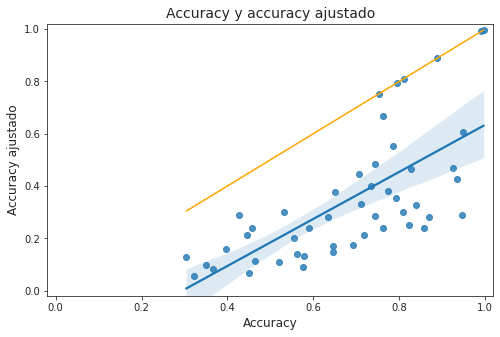

In [62]:
sns.set_style('ticks')

fig, ax = plt.subplots(1, 1,figsize=(8,5))
font_titles=14
font_labels=12

sns.regplot(data=naive_5_05_evalua_accuracy_vld,
            x='accuracy regresor', 
            y='accuracy ajustado regresor')

sns.lineplot(data=naive_5_05_evalua_accuracy_vld,
                x='accuracy regresor',
                y='accuracy regresor',color='orange')

ax.set_title('Accuracy y accuracy ajustado',fontsize=font_titles) 
ax.set_xlabel('Accuracy',fontsize=font_labels)
ax.set_xlim(-0.02,1.02)
ax.set_ylabel('Accuracy ajustado',fontsize=font_labels)
ax.set_ylim(-0.02,1.02)

plt.show()

In [63]:
naive_5_05_evalua_accuracy_vld[['accuracy regresor','accuracy ajustado regresor']].corr()

,accuracy regresor,accuracy ajustado regresor
accuracy regresor,1.000000,0.690173
accuracy ajustado regresor,0.690173,1.000000


In [64]:
explora_accuracy=naive_5_05_evalua_accuracy_vld

explora_accuracy['dif acc']=explora_accuracy['accuracy regresor']-explora_accuracy['accuracy ajustado regresor']
explora_accuracy[explora_accuracy['dif acc']<.1].sort_values(by=['accuracy regresor','dif acc'],ascending=False)
# Los puntos próximos a la recta identidad: 

,num pred por regresor,cat target por regresor (train),num obs regresor,num aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor,dif acc
regresor: titulo_ppal_,,,,,,,,,,,
Grado Medicina,1,9,704,702,702.000000,0.997159,0.997159,0.073525,0.073316,0.073316,0.000000
Grado Odontología,1,4,118,117,117.000000,0.991525,0.991525,0.012324,0.012219,0.012219,0.000000
Grado Fisioterapia,1,17,36,32,32.000000,0.888889,0.888889,0.003760,0.003342,0.003342,0.000000
Grado Enfermería,1,25,37,30,30.000000,0.810811,0.810811,0.003864,0.003133,0.003133,0.000000
Grado Farmacia,1,19,206,164,164.000000,0.796117,0.796117,0.021514,0.017128,0.017128,0.000000
Grado Trabajo social,2,45,38,29,25.314136,0.763158,0.666161,0.003969,0.003029,0.002644,0.096996
Grado Veterinaria,1,27,307,231,231.000000,0.752443,0.752443,0.032063,0.024125,0.024125,0.000000


In [65]:
# Ilustra conveniencia de accuracy ajustado: 
explora_accuracy[explora_accuracy.index=='Máster Servicios de transporte']

,num pred por regresor,cat target por regresor (train),num obs regresor,num aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor,dif acc
regresor: titulo_ppal_,,,,,,,,,,,


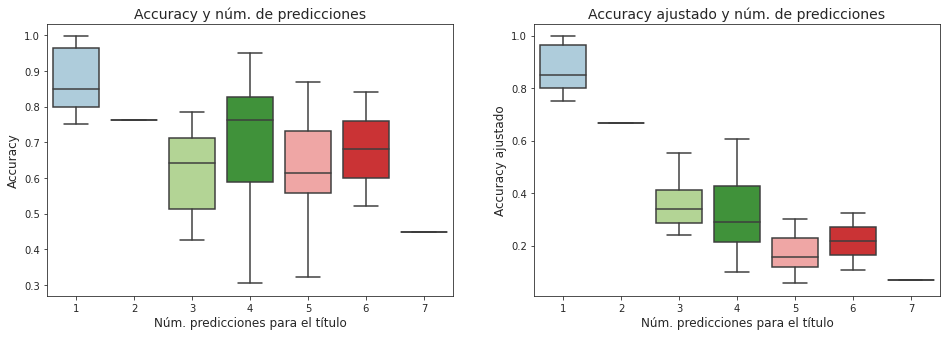

In [66]:
sns.set_style('ticks')

fig, [ax1, ax2] = plt.subplots(1, 2,figsize=(16,5))
font_titles=14
font_labels=12

sns.boxplot(ax=ax1,data=naive_5_05_evalua_accuracy_vld,
                x='num pred por regresor',
                y='accuracy regresor',
                palette='Paired')
ax1.set_title('Accuracy y núm. de predicciones',fontsize=font_titles) 
ax1.set_xlabel('Núm. predicciones para el título',fontsize=font_labels)
ax1.set_ylabel('Accuracy',fontsize=font_labels)

sns.boxplot(ax=ax2,data=naive_5_05_evalua_accuracy_vld,
                x='num pred por regresor',
                y='accuracy ajustado regresor',
                palette='Paired')
ax2.set_title('Accuracy ajustado y núm. de predicciones',fontsize=font_titles) 
ax2.set_xlabel('Núm. predicciones para el título',fontsize=font_labels)
ax2.set_ylabel('Accuracy ajustado',fontsize=font_labels)

fig.subplots_adjust(hspace=.5)
plt.show()

In [67]:
# El accuracy decrece con el núm de predicciones porque más predicciones implica menos concentración en las 
# ocupaciones de los titulados. En el no ajustado se nota menos porque se compensa con más predicciones. En el 
# ajustado se aprecia el efecto (las predicciones débiles puntuan menos)

In [68]:
naive_5_05_evalua_accuracy_vld[['num pred por regresor','accuracy regresor']].corr()

,num pred por regresor,accuracy regresor
num pred por regresor,1.000000,-0.362692
accuracy regresor,-0.362692,1.000000


In [69]:
naive_5_05_evalua_accuracy_vld[['num pred por regresor','accuracy ajustado regresor']].corr()

,num pred por regresor,accuracy ajustado regresor
num pred por regresor,1.000000,-0.843362
accuracy ajustado regresor,-0.843362,1.000000


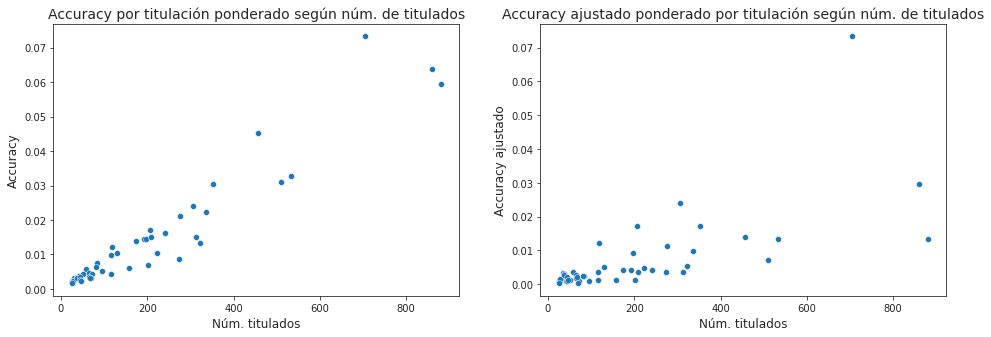

In [70]:
sns.set_style('ticks')

fig, [ax1, ax2] = plt.subplots(1, 2,figsize=(16,5))
font_titles=14
font_labels=12

sns.scatterplot(ax=ax1,data=naive_5_05_evalua_accuracy_vld,
                x='num obs regresor',
                y='accuracy ponderado regresor')
ax1.set_title('Accuracy por titulación ponderado según núm. de titulados',fontsize=font_titles) 
ax1.set_xlabel('Núm. titulados',fontsize=font_labels)
ax1.set_ylabel('Accuracy',fontsize=font_labels)

sns.scatterplot(ax=ax2,data=naive_5_05_evalua_accuracy_vld,
                x='num obs regresor',
                y='accuracy ajustado ponderado regresor')
ax2.set_title('Accuracy ajustado ponderado por titulación según núm. de titulados',fontsize=font_titles) 
ax2.set_xlabel('Núm. titulados',fontsize=font_labels)
ax2.set_ylabel('Accuracy ajustado',fontsize=font_labels)

fig.subplots_adjust(hspace=.5)
plt.show()

In [71]:
# Accuracy ajustado minora el efecto de ponderación por núm. de titulados: las titulaciones con más peso 
# (más titulados) pesan más en el agregado porque tienen ponderación más fuerte . Esto oculta que pueden 
# tener predicciones menos firmes (más ocupaciones posibles, menos prob). El accuracy ajustado corrige este
# efecto. 
# Naturalmente, el accuracy ponderado es creciente con el núm. de titulados. 
#######################################################Cuidado con el eje y arriba

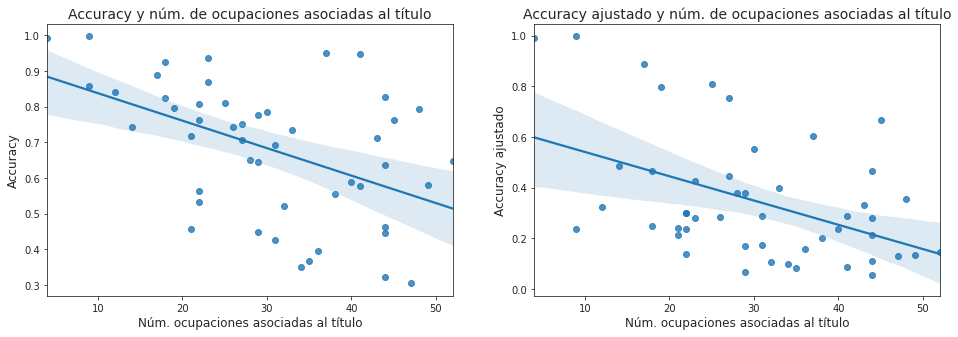

In [72]:
sns.set_style('ticks')

fig, [ax1, ax2] = plt.subplots(1, 2,figsize=(16,5))
font_titles=14
font_labels=12

sns.regplot(ax=ax1,data=naive_5_05_evalua_accuracy_vld,
                x='cat target por regresor (train)',
                y='accuracy regresor')
ax1.set_title('Accuracy y núm. de ocupaciones asociadas al título',fontsize=font_titles) 
ax1.set_xlabel('Núm. ocupaciones asociadas al título',fontsize=font_labels)
ax1.set_ylabel('Accuracy',fontsize=font_labels)

sns.regplot(ax=ax2,data=naive_5_05_evalua_accuracy_vld,
                x='cat target por regresor (train)',
                y='accuracy ajustado regresor')
ax2.set_title('Accuracy ajustado y núm. de ocupaciones asociadas al título',fontsize=font_titles) 
ax2.set_xlabel('Núm. ocupaciones asociadas al título',fontsize=font_labels)
ax2.set_ylabel('Accuracy ajustado',fontsize=font_labels)

fig.subplots_adjust(hspace=.5)
plt.show()

In [73]:
naive_5_05_evalua_accuracy_vld[['cat target por regresor (train)','accuracy regresor']].corr()

,cat target por regresor (train),accuracy regresor
cat target por regresor (train),1.000000,-0.484052
accuracy regresor,-0.484052,1.000000


In [74]:
naive_5_05_evalua_accuracy_vld[['cat target por regresor (train)','accuracy ajustado regresor']].corr()

,cat target por regresor (train),accuracy ajustado regresor
cat target por regresor (train),1.000000,-0.461591
accuracy ajustado regresor,-0.461591,1.000000


# Métricas de evaluación: recall

In [75]:
def naive_evalua_recall(clasificador,data):
    
    evalua=naive_evalua(clasificador=clasificador,data=data)
    
    import re
    lista_re_target=list(filter(lambda col: re.search('.*target.*',col),evalua.columns))
    lista_re_target=list(filter(lambda col: re.search('^(?!.*regresor.*)',col),lista_re_target))
    
    evalua=evalua[lista_re_target].drop_duplicates()
    evalua.set_index(evalua.columns[0],inplace=True)
    evalua.sort_values(by='recall target',ascending=False,inplace=True)

    return evalua

In [76]:
naive_5_05_evalua_recall_vld=naive_evalua_recall(clasificador=naive_5_05_train,data=df_vld)

In [77]:
naive_5_05_evalua_recall_vld.shape, df_vld['ocupacion_'].nunique() # Comprobación

((58, 8), 58)

In [78]:
naive_5_05_evalua_recall_vld.head()

,num obs target,num aciertos por cat target,aciertos ajustados por cat target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target
target: ocupacion_,,,,,,,,
Prof sanitarios,1505,1470,1309.834977,0.976744,0.870322,0.157180,0.153525,0.136797
Prof derecho,508,492,274.616601,0.968504,0.540584,0.053055,0.051384,0.028681
"Prof ciencias, matemáticas e ingeniería",1209,1133,515.888606,0.937138,0.426707,0.126266,0.118329,0.053879
Prof enseñanza,833,713,371.547213,0.855942,0.446035,0.086997,0.074465,0.038804
"Empleados servicios financieros, contables y de apoyo",899,756,163.350026,0.840934,0.181702,0.093890,0.078956,0.017060


In [79]:
naive_5_05_evalua_recall_vld.tail()

,num obs target,num aciertos por cat target,aciertos ajustados por cat target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target
target: ocupacion_,,,,,,,,
Peones de industrias manufactureras,26,0,0.0,0.0,0.0,0.002715,0.0,0.0
Política y dirección Admón Pública,38,0,0.0,0.0,0.0,0.003969,0.0,0.0
Gerentes em servicios excepto hostelería y comercio,51,0,0.0,0.0,0.0,0.005326,0.0,0.0
Conductores vehículos transporte urbano o carretera,10,0,0.0,0.0,0.0,0.001044,0.0,0.0
Trabajadores especializados electricidad y electrotecnología,1,0,0.0,0.0,0.0,0.000104,0.0,0.0


In [80]:
#with pd.option_context("display.max_rows", naive_5_05_evalua_recall_vld.shape[0]):
#    display(naive_5_05_evalua_recall_vld)

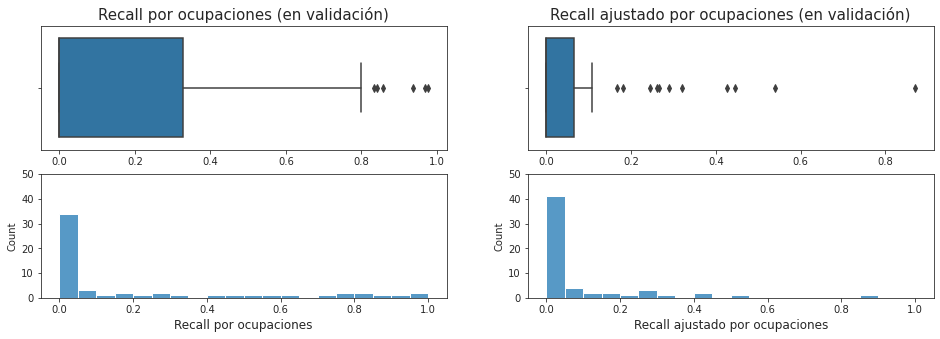

In [81]:
sns.set_style('ticks')

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2,figsize=(16,5))
font_titles=15
font_labels=12

sns.boxplot(ax=ax1,data=naive_5_05_evalua_recall_vld,x='recall target')
ax1.set_title('Recall por ocupaciones (en validación)',fontsize=font_titles) 
ax1.set_xlabel('',fontsize=font_labels)

sns.boxplot(ax=ax2,data=naive_5_05_evalua_recall_vld,x='recall ajustado target')
ax2.set_title('Recall ajustado por ocupaciones (en validación)',fontsize=font_titles)
ax2.set_xlabel('',fontsize=font_labels)

sns.histplot(ax=ax3,data=naive_5_05_evalua_recall_vld,x='recall target',bins=np.arange(0,1.05,0.05))
ax3.set_xlabel('Recall por ocupaciones',fontsize=font_labels)
ax3.set_ylim(0,50)

sns.histplot(ax=ax4,data=naive_5_05_evalua_recall_vld,x='recall ajustado target',bins=np.arange(0,1.05,0.05))
ax4.set_xlabel('Recall ajustado por ocupaciones',fontsize=font_labels)
ax4.set_ylim(0,50)

fig.subplots_adjust(hspace=.2)
plt.show()

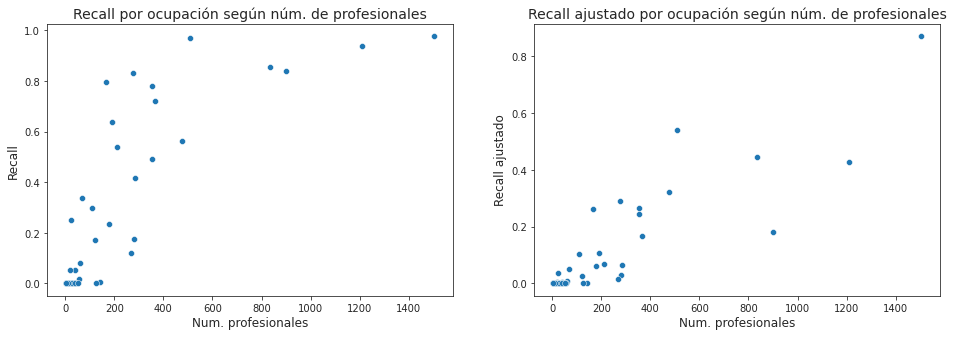

In [82]:
sns.set_style('ticks')

fig, [ax1, ax2] = plt.subplots(1, 2,figsize=(16,5))
font_titles=14
font_labels=12


sns.scatterplot(ax=ax1,data=naive_5_05_evalua_recall_vld,x='num obs target',y='recall target')
ax1.set_title('Recall por ocupación según núm. de profesionales',fontsize=font_titles)
ax1.set_xlabel('Num. profesionales',fontsize=font_labels)
ax1.set_ylabel('Recall',fontsize=font_labels)

sns.scatterplot(ax=ax2,data=naive_5_05_evalua_recall_vld,x='num obs target',y='recall ajustado target')
ax2.set_title('Recall ajustado por ocupación según núm. de profesionales',fontsize=font_titles)
ax2.set_xlabel('Num. profesionales',fontsize=font_labels)
ax2.set_ylabel('Recall ajustado',fontsize=font_labels)

fig.subplots_adjust(hspace=.5)
plt.show()

In [83]:
display(naive_5_05_evalua_recall_vld[['num obs target','recall target']].corr(),
        naive_5_05_evalua_recall_vld[['num obs target','recall ajustado target']].corr())

,num obs target,recall target
num obs target,1.000000,0.814377
recall target,0.814377,1.000000


,num obs target,recall ajustado target
num obs target,1.000000,0.888656
recall ajustado target,0.888656,1.000000


## Conclusiones

###### 1. El rendimiento evaluado por títulos (accuracy) es muy superior al recall evaluado por ocupaciones    

- El dataset es una **encuesta sobre titulados universitarios**: el muestreo está diseñado para garantizar una presencia representativa de los títulos universitarios, no de las ocupaciones profesionales. Los puestos de trabajo que no requieren formación universitaria están infrarepresentados respecto a su peso en la población general.  


###### 2. El accuracy para cada título es poco dependiente del número de egresados de la titulación     

###### 3. El recall por ocupaciones tiene una relación fuerte y directa con el número de profesionales encuestados  

- El **peor rendimiento** se da, sobre todo, en **ocupaciones que no requieren titulación universitaria**: las ocupaciones con **recall nulo** son profesiones no cualificadas u ocupaciones cuya formación especializada es no universitaria, con las excepciones de los profesionales en política y dirección de la Administración Pública y los profesionales de apoyo en finanzas y matemáticas. 
- Las ocupaciones con recall nulo son, también, las más infrarepresentadas en la encuesta. 

# Metricas de evaluación: precisión

In [84]:
# Dataframe para pruebas de función naive_evalua_rhs: 
df_prueba=pd.DataFrame({'titulo_ppal_':['Grado Derecho','Grado Derecho','Grado Derecho',
                                        'Grado Administración y empresa','Grado Medicina'],
                        'ocupacion_':['Prof derecho','Prof derecho',
                                      'Empleados servicios financieros, contables y de apoyo','Prof derecho',
                                      'Prof sanitarios']},
                       index=[50,51,52,53,54])

In [85]:
def naive_evalua_rhs(clasificador, data):
    
    import re
    regresor=list(filter(lambda col: col.startswith('regresor:'),clasificador.columns))[0].split(' ')[1]
    target=list(filter(lambda col: col.startswith('target:'),clasificador.columns))[0].split(' ')[1]
    
    evalua=data[[regresor,target]]
    
    total_obs=evalua.shape[0]
    
    # Num. de observaciones para cada categoría del target (numerador pesos de precisiones ponderadas):
    total_obs_por_cat_target=evalua.groupby(target).agg(['count']) # cuenta sobre target observado
    total_obs_por_cat_target.columns=total_obs_por_cat_target.columns.to_flat_index()
    evalua=evalua.merge(total_obs_por_cat_target,on=target,how='outer') 
    evalua.rename(columns={evalua.columns[-1]:'num obs cat target'},inplace=True)
    
    # Columnas con predicciones (lista targets predichos y lista probabilidades)
    evalua['prediccion']=evalua[regresor]\
                         .apply(lambda valor: naive_prediccion(clasificador,valor)['prediccion'].tolist())
    evalua['prediccion probs']=evalua[regresor]\
                         .apply(lambda valor: naive_prediccion(clasificador,valor)['probabilidad'].tolist())
    
    # Columna 'suma de prob. de pred. por regresor' (denominador de acierto ajustado por probabilidad):
    # Se hace aquí para eleminar listas del dataframe (interfieren en comparaciones de filas)
    evalua['suma prob pred por regresor']=evalua['prediccion probs'].apply(lambda lista: sum(lista))
    
    # Núm predicciones:
    evalua['num pred para regresor']=evalua['prediccion'].apply(lambda lista:len(lista))
    max_rank=evalua['num pred para regresor'].max()
    
    for i in range(max_rank):
        # Se sacan las predicciones de la lista y se convierten en columnas:  
        evalua['pred'+str(i)]=evalua['prediccion'][evalua['num pred para regresor']>=i+1]\
                             .apply(lambda lista:lista[i])
        # Se sacan las probabilidades de las predicciones de la lista y se convierten en columnas: 
        evalua['p'+str(i)]=evalua['prediccion probs'][evalua['num pred para regresor']>=i+1]\
                          .apply(lambda lista:lista[i])   

    del evalua['prediccion'], evalua['prediccion probs'] # listas interfieren en comparaciones de filas
    
    # Se odenan todas la predicciones para una observacion (previamente en cols) en filas:
    # Para cada obs., una fila por predicción: filas dénticas salvo por el valor de la predicción y su prob. 
    # Las obs. dejan de corresponderse con filas (varias pred. para una obs.)
    # Las predicciones ordenadas en 2 columnas: predicciones del target y prob. de las predicciones
    
    evalua.rename(columns={'pred0':'predicciones target','p0':'predicciones prob'},inplace=True)
    
    for i in range(1,max_rank):
        aux=evalua[evalua.columns.drop(['predicciones target','predicciones prob'])]
        aux.rename(columns={'pred'+str(i):'predicciones target','p'+str(i):'predicciones prob'},inplace=True)     
        # Prescinde de filas con nan por titulaciones con menos predicciones que otras: 
        aux=aux[aux['predicciones target'].notna()]
        del evalua['pred'+str(i)], evalua['p'+str(i)]
        # Merge conservando índices para identificar observaciones distintas (no se corresponden con filas):
        for df in [evalua,aux]:
            df.reset_index(inplace=True)
        evalua=evalua.merge(aux,how='outer')
        evalua.drop_duplicates(inplace=True)
        evalua.set_index('index',inplace=True)
    
    # Para desligar por índice y asignar valores distintos en col. nuevas para misma obs.: 
    evalua.reset_index(drop=False,inplace=True) 
    evalua.sort_values(by='index',inplace=True)
    
    # Aciertos (binaria):
    evalua['acierto']=0
    evalua['acierto'].mask(evalua['predicciones target']==evalua[target],1,inplace=True)
   
    # Probabilidades de las predicciones acertadas:
    evalua['prob pred acertada']=evalua[evalua['acierto']==1]['predicciones prob']
    
    # Núm. de aciertos (binaria) para cada predicción: 
    aciertos_por_prediccion=evalua[['predicciones target','acierto']].groupby('predicciones target').agg(['sum'])
    aciertos_por_prediccion.columns=aciertos_por_prediccion.columns.to_flat_index()
    evalua=evalua.merge(aciertos_por_prediccion,on='predicciones target')
    evalua.rename(columns={evalua.columns[-1]:'num pred acertadas'},inplace=True)
    
    # Núm. de repeticiones de cada predicción: 
    repeticiones_pred=evalua[['predicciones target','acierto']].groupby('predicciones target').agg(['count'])
    repeticiones_pred.columns=repeticiones_pred.columns.to_flat_index()
    evalua=evalua.merge(repeticiones_pred,on='predicciones target')
    evalua.rename(columns={evalua.columns[-1]:'num pred'},inplace=True)

    # Acierto ajustado: proporción de la probabilidad de predicción acertada sobre suma probs. de predicciones:  
    evalua['acierto ajustado']=evalua[evalua['acierto']==1]['prob pred acertada']\
                              .div(evalua[evalua['acierto']==1]['suma prob pred por regresor'])

    # Suma aciertos ajustados para cada predicción: 
    suma_aciertos_ajustados=evalua[['predicciones target','acierto ajustado']]\
                                           .groupby('predicciones target').agg(['sum'])
    suma_aciertos_ajustados.columns=suma_aciertos_ajustados.columns.to_flat_index()
    evalua=evalua.merge(suma_aciertos_ajustados,on='predicciones target')
    evalua.rename(columns={evalua.columns[-1]:'aciertos ajustados por pred'},inplace=True)
    
    # Precisión y precisión ajustada por predicción: 
    evalua['precision pred']=evalua['num pred acertadas'].div(evalua['num pred'])
    evalua['precision ajustada pred']=evalua['aciertos ajustados por pred']\
                                          .div(evalua['num pred'])
   
    # Pesos de predicciones = num. obs. de target predicho entre total obs.: 
    pesos_pred=evalua[[target,'num obs cat target']]
    pesos_pred['peso pred']=pesos_pred['num obs cat target']/total_obs
    pesos_pred=pesos_pred[[target,'peso pred']]
    pesos_pred.rename(columns={target:'predicciones target'},inplace=True)
    pesos_pred.drop_duplicates(inplace=True)
    evalua=evalua.merge(pesos_pred,on='predicciones target',how='left')
    evalua['peso pred'].fillna(0,inplace=True) # para predicciones no observadas
    
    # Precisión y precisión ajustada ponderada para cada predicción:    
    evalua['precision ponderada pred']=evalua['precision pred']*evalua['peso pred']
    evalua['precision ajustada ponderada pred']=evalua['precision ajustada pred']*evalua['peso pred']
    
    # Formato:
    evalua.set_index('index',inplace=True)
    evalua.sort_index(inplace=True)
    evalua.rename(columns={regresor:'regresor: '+regresor, target:'target: '+target},inplace=True)

    return evalua

In [86]:
prueba=naive_evalua_rhs(clasificador=naive_5_05_train, data=df_prueba)
prueba

,regresor: titulo_ppal_,target: ocupacion_,num obs cat target,suma prob pred por regresor,num pred para regresor,predicciones target,predicciones prob,acierto,prob pred acertada,num pred acertadas,num pred,acierto ajustado,aciertos ajustados por pred,precision pred,precision ajustada pred,peso pred,precision ponderada pred,precision ajustada ponderada pred
index,,,,,,,,,,,,,,,,,,
0,Grado Derecho,Prof derecho,3,0.635549,4,Prof derecho,0.391337,1,0.391337,3,4,0.615746,1.326777,0.75,0.331694,0.6,0.45,0.199017
0,Grado Derecho,Prof derecho,3,0.635549,4,Empleados administrativos sin atención al público,0.073189,0,NaN,0,4,NaN,0.000000,0.00,0.000000,0.0,0.00,0.000000
0,Grado Derecho,Prof derecho,3,0.635549,4,"Empleados servicios financieros, contables y de apoyo",0.050037,0,NaN,1,4,NaN,0.078731,0.25,0.019683,0.2,0.05,0.003937
0,Grado Derecho,Prof derecho,3,0.635549,4,"Expertos en gestión, finanzas, comercio, etc",0.120986,0,NaN,0,4,NaN,0.000000,0.00,0.000000,0.0,0.00,0.000000
1,Grado Derecho,Prof derecho,3,0.635549,4,"Empleados servicios financieros, contables y de apoyo",0.050037,0,NaN,1,4,NaN,0.078731,0.25,0.019683,0.2,0.05,0.003937
1,Grado Derecho,Prof derecho,3,0.635549,4,"Expertos en gestión, finanzas, comercio, etc",0.120986,0,NaN,0,4,NaN,0.000000,0.00,0.000000,0.0,0.00,0.000000
1,Grado Derecho,Prof derecho,3,0.635549,4,Prof derecho,0.391337,1,0.391337,3,4,0.615746,1.326777,0.75,0.331694,0.6,0.45,0.199017
1,Grado Derecho,Prof derecho,3,0.635549,4,Empleados administrativos sin atención al público,0.073189,0,NaN,0,4,NaN,0.000000,0.00,0.000000,0.0,0.00,0.000000
2,Grado Administración y empresa,Prof derecho,3,0.579397,5,Prof derecho,0.055208,1,0.055208,3,4,0.095285,1.326777,0.75,0.331694,0.6,0.45,0.199017


### Evaluación desagregada (en validación) 

In [87]:
naive_5_05_evalua_rhs_vld=naive_evalua_rhs(clasificador=naive_5_05_train, data=df_vld)

In [88]:
naive_5_05_evalua_rhs_vld.head()

,regresor: titulo_ppal_,target: ocupacion_,num obs cat target,suma prob pred por regresor,num pred para regresor,predicciones target,predicciones prob,acierto,prob pred acertada,num pred acertadas,num pred,acierto ajustado,aciertos ajustados por pred,precision pred,precision ajustada pred,peso pred,precision ponderada pred,precision ajustada ponderada pred
index,,,,,,,,,,,,,,,,,,
0,Grado Informática,"Prof ciencias, matemáticas e ingeniería",1209,0.766667,4,Profesionales IT,0.412745,0,NaN,174,932,NaN,86.616804,0.186695,0.092936,0.036971,0.006902,0.003436
0,Grado Informática,"Prof ciencias, matemáticas e ingeniería",1209,0.766667,4,Técnicos TI,0.200980,0,NaN,264,1071,NaN,61.265809,0.246499,0.057204,0.038329,0.009448,0.002193
0,Grado Informática,"Prof ciencias, matemáticas e ingeniería",1209,0.766667,4,"Prof ciencias, matemáticas e ingeniería",0.091176,1,0.091176,1133,2883,0.118926,515.888606,0.392993,0.178942,0.126266,0.049622,0.022594
0,Grado Informática,"Prof ciencias, matemáticas e ingeniería",1209,0.766667,4,Prof enseñanza,0.061765,0,NaN,713,4853,NaN,371.547213,0.146919,0.076560,0.086997,0.012782,0.006661
1,Grado Informática,"Prof ciencias, matemáticas e ingeniería",1209,0.766667,4,Profesionales IT,0.412745,0,NaN,174,932,NaN,86.616804,0.186695,0.092936,0.036971,0.006902,0.003436


In [89]:
naive_5_05_evalua_rhs_vld['predicciones target'].nunique()
# Núm. de predicciones distintas:

27

In [90]:
naive_5_05_evalua_rhs_vld['target: ocupacion_'].nunique()
# Núm. de ocupaciones distintas observadas: 

58

## Precisión agregada por predicciones

In [91]:
def naive_evalua_precision(clasificador,data):
    
    """
    adaptar
    """
    
    evalua=naive_evalua_rhs(clasificador=clasificador,data=data)
    
    import re
    lista_re_pred=list(filter(lambda col: re.search('.*pred.*',col),evalua.columns))
    lista_re_pred=list(filter(lambda col: re.search('^(?!.*regresor.*)',col),lista_re_pred))
    lista_re_pred=list(filter(lambda col: re.search('^(?!.*prob.*)',col),lista_re_pred))
    lista_re_pred=[lista_re_pred[0]]+[lista_re_pred[2]]+[lista_re_pred[1]]+lista_re_pred[3:]
    
    evalua=evalua[lista_re_pred].drop_duplicates()
    
    evalua.set_index('predicciones target',inplace=True)
    evalua.sort_values(by='precision pred',ascending=False,inplace=True)

    return evalua

In [92]:
naive_5_05_precision_vld=naive_evalua_precision(clasificador=naive_5_05_train,data=df_vld)

In [93]:
naive_5_05_precision_vld.shape[0], df_vld['ocupacion_'].nunique() # Comprobación: 
# El núm de ocupaciones predichas es la cuarta parte del núm. de ocupaciones observadas en validación

(27, 58)

In [94]:
naive_5_05_precision_vld

,num pred,num pred acertadas,aciertos ajustados por pred,precision pred,precision ajustada pred,peso pred,precision ponderada pred,precision ajustada ponderada pred
predicciones target,,,,,,,,
Prof sanitarios,2559,1470,1309.834977,0.574443,0.511854,0.157180,0.090291,0.080453
"Prof ciencias, matemáticas e ingeniería",2883,1133,515.888606,0.392993,0.178942,0.126266,0.049622,0.022594
"Empleados servicios financieros, contables y de apoyo",2373,756,163.350026,0.318584,0.068837,0.093890,0.029912,0.006463
Prof derecho,1857,492,274.616601,0.264943,0.147882,0.053055,0.014057,0.007846
Técnicos TI,1071,264,61.265809,0.246499,0.057204,0.038329,0.009448,0.002193
Prof ciencias sociales,1130,267,152.057413,0.236283,0.134564,0.049504,0.011697,0.006661
Profesionales IT,932,174,86.616804,0.186695,0.092936,0.036971,0.006902,0.003436
Prof enseñanza,4853,713,371.547213,0.146919,0.076560,0.086997,0.012782,0.006661
Prof eduación especial y no reglada,869,118,18.524709,0.135788,0.021317,0.029556,0.004013,0.000630


# Resúmenes de métricas de evaluación 

In [95]:
def naive_evalua_criterio_resumen(clasificador,data,criterio):
    """ Función instrumental: generaliza el proceso de resumen de la evaluación de acuerdo con un 'criterio' 
    que se concretará como accuracy, como recall o como precision.
    """
    if criterio=='accuracy':
        evalua=naive_evalua_accuracy(clasificador=clasificador,data=data)
    if criterio=='recall':
        evalua=naive_evalua_recall(clasificador=clasificador,data=data)
    if criterio=='precision':
        evalua=naive_evalua_precision(clasificador=clasificador,data=data)
    
    evalua_resumen=evalua.agg(['sum','mean','median','min','argmin','max','argmax'])
    
    # Ajustes argmin y argmax: 
    for col in evalua.columns: 
        for arg in ['argmin','argmax']:
            indice=int(evalua_resumen.loc[arg,col])
            evalua_resumen.loc[arg,col]=evalua.index[indice]

    return evalua_resumen

In [96]:
def naive_evalua_accuracy_resumen(clasificador,data):
    
    evalua=naive_evalua_criterio_resumen(clasificador=clasificador,data=data,criterio='accuracy')
    
    # Agregados sinsentidos: 
    evalua.loc['sum','accuracy regresor']=''
    evalua.loc['sum','accuracy ajustado regresor']=''
    
    return evalua

In [97]:
def naive_evalua_recall_resumen(clasificador,data):
    
    evalua=naive_evalua_criterio_resumen(clasificador=clasificador,data=data,criterio='recall')
    
    # Agregados sinsentidos: 
    evalua.loc['sum','recall target']=''
    evalua.loc['sum','recall ajustado target']=''
    
    return evalua

In [98]:
def naive_evalua_precision_resumen(clasificador,data):
    
    evalua=naive_evalua_criterio_resumen(clasificador=clasificador,data=data,criterio='precision')
    
    # Agregados sinsentidos: 
    evalua.loc['sum','precision pred']=''
    evalua.loc['sum','precision ajustada pred']=''
    
    return evalua

In [99]:
naive_5_05_evalua_accuracy_resumen_vld=naive_evalua_accuracy_resumen(clasificador=naive_5_05_train,data=df_vld)
naive_5_05_evalua_accuracy_resumen_vld

,num pred por regresor,cat target por regresor (train),num obs regresor,num aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor
sum,189,1479,9575,6475,3249.16,,,1,0.67624,0.339338
mean,3.85714,30.1837,195.408,132.143,66.3095,0.682218,0.347812,0.0204082,0.0138008,0.00692527
median,4,29,117,65,32,0.71875,0.285859,0.0122193,0.00678851,0.00334204
min,1,4,25,15,2.31609,0.304029,0.0554544,0.00261097,0.00156658,0.000241889
argmin,Grado Medicina,Grado Odontología,Grado Literatura,Grado Ciencias del trabajo,Grado Ciencias del trabajo,Grado Historia,Grado Bellas artes,Grado Literatura,Grado Ciencias del trabajo,Grado Ciencias del trabajo
max,7,52,880,702,702,0.997159,0.997159,0.091906,0.0733159,0.0733159
argmax,Grado Geografía,Grado Administración y empresa,Grado Administración y empresa,Grado Medicina,Grado Medicina,Grado Medicina,Grado Medicina,Grado Administración y empresa,Grado Medicina,Grado Medicina


In [100]:
naive_5_05_evalua_recall_resumen_vld=naive_evalua_recall_resumen(clasificador=naive_5_05_train,data=df_vld)
naive_5_05_evalua_recall_resumen_vld

,num obs target,num aciertos por cat target,aciertos ajustados por cat target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target
sum,9575,6475,3249.16,,,1,0.67624,0.339338
mean,165.086,111.638,56.0201,0.209641,0.0793946,0.0172414,0.0116593,0.00585066
median,36,0,0,0,0,0.00375979,0,0
min,1,0,0,0,0,0.000104439,0,0
argmin,Montadores y ensambladores en fábricas,"Mecánicos de precisión, artesanos y artes gráficas","Mecánicos de precisión, artesanos y artes gráficas","Mecánicos de precisión, artesanos y artes gráficas","Mecánicos de precisión, artesanos y artes gráficas",Montadores y ensambladores en fábricas,"Mecánicos de precisión, artesanos y artes gráficas","Mecánicos de precisión, artesanos y artes gráficas"
max,1505,1470,1309.83,0.976744,0.870322,0.15718,0.153525,0.136797
argmax,Prof sanitarios,Prof sanitarios,Prof sanitarios,Prof sanitarios,Prof sanitarios,Prof sanitarios,Prof sanitarios,Prof sanitarios


In [101]:
naive_5_05_evalua_precision_resumen_vld=naive_evalua_precision_resumen(clasificador=naive_5_05_train,data=df_vld)
naive_5_05_evalua_precision_resumen_vld
# suma pesos pred != 1 : pesos de predicciones imputados por pesos observaciones

,num pred,num pred acertadas,aciertos ajustados por pred,precision pred,precision ajustada pred,peso pred,precision ponderada pred,precision ajustada ponderada pred
sum,36340,6475,3249.16,,,0.941305,0.24606,0.141204
mean,1345.93,239.815,120.339,0.124585,0.0550637,0.0348632,0.00911333,0.00522979
median,869,113,14.4943,0.0646465,0.019511,0.0218277,0.00152472,0.000364749
min,31,0,0,0,0,0.00177546,0,0
argmin,Ocupaciones militares,Ocupaciones militares,Ocupaciones militares,Ocupaciones militares,Ocupaciones militares,Ocupaciones militares,Ocupaciones militares,Ocupaciones militares
max,4853,1470,1309.83,0.574443,0.511854,0.15718,0.0902911,0.0804533
argmax,Prof enseñanza,Prof sanitarios,Prof sanitarios,Prof sanitarios,Prof sanitarios,Prof sanitarios,Prof sanitarios,Prof sanitarios


# Evaluación: agregados 

In [102]:
def naive_evalua_regresor(clasificador,data):
    
    import re
    
    resumen=naive_evalua_accuracy(clasificador=clasificador,data=data)
    lista_re_accuracy_1=list(filter(lambda col: re.search('.*accuracy.*',col),resumen.columns))
    lista_re_accuracy_2=list(filter(lambda col: re.search('.*peso.*',col),resumen.columns))
    resumen=resumen[lista_re_accuracy_1+lista_re_accuracy_2]
    resumen.index.rename('regresor',inplace=True)

    # Formato: 
    columnas=[resumen.columns[-1]]+resumen.columns[:-1].tolist()
    resumen=resumen[columnas]
    dicc_col=dict(zip(resumen.columns,list(map(lambda col: col.rsplit(' ',1)[0],resumen.columns))))
    resumen.rename(columns=dicc_col,inplace=True)
    resumen.sort_values(by='accuracy',ascending=False,inplace=True)

    return resumen

In [103]:
naive_5_05_regresor=naive_evalua_regresor(clasificador=naive_5_05_train,data=df_vld)

In [104]:
naive_5_05_regresor.sum()

peso                            1.000000
accuracy                       33.428662
accuracy ajustado              17.042776
accuracy ponderado              0.676240
accuracy ajustado ponderado     0.339338
dtype: float64

In [105]:
naive_5_05_regresor.head()

,peso,accuracy,accuracy ajustado,accuracy ponderado,accuracy ajustado ponderado
regresor,,,,,
Grado Medicina,0.073525,0.997159,0.997159,0.073316,0.073316
Grado Odontología,0.012324,0.991525,0.991525,0.012219,0.012219
Grado Ingeniería electrónica industrial y automática,0.006162,0.949153,0.605725,0.005849,0.003732
Grado Informática,0.047728,0.947484,0.290158,0.045222,0.013849
Grado Ingeniería naval y oceánica,0.003238,0.935484,0.425179,0.003029,0.001377


In [106]:
def naive_evalua_target(clasificador,data):
    
    import re
    
    resumen_precision=naive_evalua_precision(clasificador=clasificador,data=data)
    lista_re_precision=list(filter(lambda col: re.search('.*precision.*',col),resumen_precision.columns))
    resumen_precision=resumen_precision[lista_re_precision]
    resumen_precision.index.rename('target',inplace=True)
    
    resumen_recall=naive_evalua_recall(clasificador=clasificador,data=data)
    lista_re_recall_1=list(filter(lambda col: re.search('.*recall.*',col),resumen_recall.columns))
    lista_re_recall_2=list(filter(lambda col: re.search('.*num.*',col),resumen_recall.columns)) 
    lista_re_recall_3=list(filter(lambda col: re.search('.*peso.*',col),resumen_recall.columns))
    resumen_recall=resumen_recall[lista_re_recall_1+lista_re_recall_2+lista_re_recall_3]
    resumen_recall.index.rename('target',inplace=True)
    
    resumen=resumen_precision.merge(resumen_recall,left_index=True,right_index=True,how='outer')

    # Formato: 
    columnas=resumen.columns[-3:].tolist()+resumen.columns[:-3].tolist()
    resumen=resumen[columnas]
    dicc_col=dict(zip(resumen.columns,list(map(lambda col: col.rsplit(' ',1)[0],resumen.columns))))
    dicc_col=dict(zip(dicc_col.keys(),list(map(lambda col: col.split('por')[0],dicc_col.values()))))
    resumen.rename(columns=dicc_col,inplace=True)
    resumen.sort_values(by=['num obs','precision','recall'],ascending=False,inplace=True)
    
    resumen['indice f1']=2*resumen['precision']*resumen['recall']/(resumen['precision']+resumen['recall'])
    resumen['indice f1 ajustado']=2*resumen['precision ajustada']*resumen['recall ajustado']\
                                  /(resumen['precision ajustada']+resumen['recall ajustado'])
    resumen['indice f1 ponderado']=resumen['indice f1']*resumen['peso']
    resumen['indice f1 ajustado ponderado']=resumen['indice f1 ajustado']*resumen['peso']

    return resumen

In [107]:
prueba=naive_evalua_target(clasificador=naive_5_05_train,data=df_prueba)
prueba

,num obs,num aciertos,peso,precision,precision ajustada,precision ponderada,precision ajustada ponderada,recall,recall ajustado,recall ponderado,recall ajustado ponderado,indice f1,indice f1 ajustado,indice f1 ponderado,indice f1 ajustado ponderado
target,,,,,,,,,,,,,,,
Prof derecho,3.0,3.0,0.6,0.75,0.331694,0.45,0.199017,1.0,0.442259,0.6,0.265355,0.857143,0.379079,0.514286,0.227448
Prof sanitarios,1.0,1.0,0.2,1.00,1.000000,0.20,0.200000,1.0,1.000000,0.2,0.200000,1.000000,1.000000,0.200000,0.200000
"Empleados servicios financieros, contables y de apoyo",1.0,1.0,0.2,0.25,0.019683,0.05,0.003937,1.0,0.078731,0.2,0.015746,0.400000,0.031492,0.080000,0.006298
Empleados administrativos sin atención al público,NaN,NaN,NaN,0.00,0.000000,0.00,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Expertos en gestión, finanzas, comercio, etc",NaN,NaN,NaN,0.00,0.000000,0.00,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Representantes e intermediarios,NaN,NaN,NaN,0.00,0.000000,0.00,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
naive_5_05_target=naive_evalua_target(clasificador=naive_5_05_train,data=df_vld)

In [109]:
naive_5_05_target.sum()

num obs                         9575.000000
num aciertos                    6475.000000
peso                               1.000000
precision                          3.363807
precision ajustada                 1.486721
precision ponderada                0.246060
precision ajustada ponderada       0.141204
recall                            12.159187
recall ajustado                    4.604887
recall ponderado                   0.676240
recall ajustado ponderado          0.339338
indice f1                          4.948277
indice f1 ajustado                 2.125954
indice f1 ponderado                0.345219
indice f1 ajustado ponderado       0.191903
dtype: float64

In [110]:
naive_5_05_target.head()

,num obs,num aciertos,peso,precision,precision ajustada,precision ponderada,precision ajustada ponderada,recall,recall ajustado,recall ponderado,recall ajustado ponderado,indice f1,indice f1 ajustado,indice f1 ponderado,indice f1 ajustado ponderado
target,,,,,,,,,,,,,,,
Prof sanitarios,1505,1470,0.157180,0.574443,0.511854,0.090291,0.080453,0.976744,0.870322,0.153525,0.136797,0.723425,0.644604,0.113708,0.101319
"Prof ciencias, matemáticas e ingeniería",1209,1133,0.126266,0.392993,0.178942,0.049622,0.022594,0.937138,0.426707,0.118329,0.053879,0.553763,0.252145,0.069922,0.031837
"Empleados servicios financieros, contables y de apoyo",899,756,0.093890,0.318584,0.068837,0.029912,0.006463,0.840934,0.181702,0.078956,0.017060,0.462103,0.099847,0.043387,0.009375
Prof enseñanza,833,713,0.086997,0.146919,0.076560,0.012782,0.006661,0.855942,0.446035,0.074465,0.038804,0.250791,0.130688,0.021818,0.011370
Prof derecho,508,492,0.053055,0.264943,0.147882,0.014057,0.007846,0.968504,0.540584,0.051384,0.028681,0.416068,0.232234,0.022074,0.012321


In [111]:
def naive_evalua_resumen(clasificador, data, nombre='naive'):
    
    resumen=naive_evalua_target(clasificador=clasificador, data=data)
    resumen=resumen[['precision ponderada', 'precision ajustada ponderada','recall ponderado',
                   'recall ajustado ponderado','indice f1 ponderado','indice f1 ajustado ponderado']]
    dicc_col=dict(zip(resumen.columns,map(lambda col: col.rsplit(' ',1)[0],resumen.columns)))
    resumen.rename(columns=dicc_col,inplace=True)
    resumen.rename(columns={'recall':'recall (o accuracy)'},inplace=True)
    
    resumen=pd.DataFrame(resumen.sum())
    resumen.rename(columns={resumen.columns[0]:str(nombre)},inplace=True)
    resumen.index.rename('medias ponderadas',inplace=True)
    
    return resumen

In [112]:
prueba=naive_evalua_resumen(clasificador=naive_5_05_train,data=df_prueba)
prueba

,naive
medias ponderadas,
precision,0.700000
precision ajustada,0.402953
recall (o accuracy),1.000000
recall ajustado,0.481102
indice f1,0.794286
indice f1 ajustado,0.433746


In [113]:
naive_5_05_resumen=naive_evalua_resumen(clasificador=naive_5_05_train,data=df_vld)

In [114]:
naive_5_05_resumen

,naive
medias ponderadas,
precision,0.246060
precision ajustada,0.141204
recall (o accuracy),0.676240
recall ajustado,0.339338
indice f1,0.345219
indice f1 ajustado,0.191903


In [115]:
naive_encuesta=naive_fit(data=df,regresor='titulo_ppal_',target='ocupacion_',max_rank=5,min_prop=0.05)

In [116]:
def naive_comparador(lista_clasificadores,lista_data):
    
    m=len(lista_clasificadores)
    if type(lista_data)!=list: 
        lista_data=[lista_data]*m
    resumen=naive_evalua_resumen(clasificador=lista_clasificadores[0], data=lista_data[0])
    #resumen.rename
    for i in range(1,m):
        evalua=naive_evalua_resumen(clasificador=lista_clasificadores[i], data=lista_data[i])
        resumen=pd.concat([resumen,evalua],axis=1)
        
    return resumen

In [117]:
prueba=naive_comparador([naive_5_05_train,naive_5_05_train],[df_prueba, df_prueba.sample(3)])
prueba

,naive,naive
medias ponderadas,,
precision,0.700000,0.555556
precision ajustada,0.402953,0.282413
recall (o accuracy),1.000000,1.000000
recall ajustado,0.481102,0.436741
indice f1,0.794286,0.700000
indice f1 ajustado,0.433746,0.341520
